<img align="center" style="max-width: 900px" src="banner.png">

<img align="right" style="max-width: 200px; height: auto" src="hsg_logo.png">

##  Bonus Lab 04 - Federated Learning (FL)

Deep Learning, Fall Semester 2022, University of St. Gallen (HSG)

In this lab, we will learn how to federate the training and evaluation of vanilla **Convolutional Neural Network (CNN)** learning. 

We will use the functionality of the [Flower](www.flower.dev) federated learning framework, to implement the federated learning setup. The different federated clients will collaboratively learn a model to classify the images of the CIFAR-10 dataset. More details on the `Flower` framework can be found via the following link https://flower.dev. Upon successful training, we will utilize the learned CNN model to classify so far unseen tiny images into distinct categories such as aeroplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. 

The figure below illustrates a high-level view on the machine learning process we aim to establish in this lab. This labs builds in large parts on the [An Introduction to Federated Learning](https://github.com/adap/flower/blob/main/doc/source/tutorial/Flower-1-Intro-to-FL-PyTorch.ipynb) notebook developed and published by the `Flower` development team.

<img align="center" style="max-width: 600px" src="./federated_learning.png">

(Image of the CNN architecture created via http://alexlenail.me/)

As always, pls. don't hesitate to ask all your questions either during the lab, post them in our CANVAS (StudyNet) forum (https://learning.unisg.ch), or send us an email (using the course email).

## 1. Lab Objectives:

After today's lab, you should be able to:

> 1. Understand the basic concepts, intuitions and major building blocks of **federated learning**.
> 2. Know how to **implement federated clients** to enable model parameter sharing and aggregation.
> 3. Understand how to **to train arbitrary models** in a federated setup collaboratively.
> 4. Know how to **define federated learning strategies** and **run federated learning simulations**.

## 2. Setup of the Jupyter Notebook Environment

The `Flower - A Friendly Federated Learning Framework` provides a unified approach to federated learning, analytics, and evaluation. It allows to federate a variety of any ML setups. Let's install the `Flower` framework by execution of the following code cell:

In [1]:
# !pip3 install -U flwr["simulation"]

(Note: You may want to restart the Colab runtime after the installation).

Ignore potential library warnings to not get distracted (don't try this at home :D ). 

In [2]:
# import warning library
import warnings

# mute potential warnings
warnings.filterwarnings('ignore')

Import the federated learning libraries:

In [3]:
# import flower libraries
import flwr as fl
from flwr.common import Metrics

Determine the installed version of the Flower library:

In [4]:
print('Available Flower library version:', fl.__version__)

Available Flower library version: 1.0.0


Similar to the previous labs, we need to import a couple of Python libraries that allow for data analysis and data visualization. We will mostly use the `PyTorch`, `Numpy`, `Sklearn`, `Matplotlib`, `Seaborn` and a few utility libraries throughout this lab:

Import Python utility libraries:

In [5]:
# import utility python libraries
import os
from datetime import datetime

Import Python data container libaries:

In [6]:
# import data container libraries
import numpy as np
from collections import OrderedDict
from typing import List, Tuple

Import Python machine / deep learning libraries:

In [7]:
# import the PyTorch deep learning library
import torch, torchvision
from torch import nn

Import Python plotting libraries:

In [8]:
# import matplotlib, seaborn, and PIL data visualization libary
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

Enable notebook matplotlib inline plotting:

In [9]:
%matplotlib inline

Create a structure of sub-directories to store the data as well as the trained neural network models:

In [10]:
 # create data sub-directory inside the Colab Notebooks directory
data_directory = './datasets/data_cifar10'
if not os.path.exists(data_directory): os.makedirs(data_directory)

 # create models sub-directory inside the Colab Notebooks directory
models_directory = './models/models_cifar10'
if not os.path.exists(models_directory): os.makedirs(models_directory)

Set a random `seed` value to obtain reproducible results:

In [11]:
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value); # set pytorch seed CPU

Enable GPU computing (if available) by setting the `device` flag and init a `CUDA` seed:

In [12]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# init deterministic GPU seed
torch.cuda.manual_seed(seed_value)

# log type of device enabled
print('[LOG] Jupyter notebook with {} computation enabled'.format(str(device)))

[LOG] Jupyter notebook with cpu computation enabled


## 3. Dataset Download and Data Assessment

The **CIFAR-10 database** (**C**anadian **I**nstitute **F**or **A**dvanced **R**esearch) is a collection of images that are commonly used to train machine learning and computer vision algorithms. The database is widely used to conduct computer vision research using machine learning and deep learning methods:

<img align="center" style="max-width: 500px; height: 500px" src="./cifar10.png">

(Source: https://www.kaggle.com/c/cifar-10)

Further details on the dataset can be obtained via: *Krizhevsky, A., 2009. "Learning Multiple Layers of Features from Tiny Images",  
( https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf )."*

The CIFAR-10 database contains **60,000 color images** (50,000 training images and 10,000 validation images). The size of each image is 32 by 32 pixels. The collection of images encompasses 10 different classes that represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. Let's define the distinct classs for further analytics:

In [13]:
cifar10_classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Thereby the dataset contains 6,000 images for each of the ten classes. The CIFAR-10 is a straightforward dataset that can be used to teach a computer how to recognize objects in images.

Let's download, transform and inspect the training images of the dataset. Therefore, we first will define the directory we aim to store the training data:

In [14]:
train_path = data_directory + '/train_cifar10'

Now, let's download the training data accordingly:

In [15]:
# define pytorch transformation into tensor format
transf = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# download and transform training images
cifar10_train_data = torchvision.datasets.CIFAR10(root=train_path, train=True, transform=transf, download=True)

Files already downloaded and verified


Verify the volume of training images downloaded:

In [16]:
# get the length of the training data
len(cifar10_train_data)

50000

Let's now decide on where we want to store the evaluation data:

In [17]:
eval_path = data_directory + '/eval_cifar10'

And download the evaluation data accordingly:

In [18]:
# define pytorch transformation into tensor format
transf = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# download and transform validation images
cifar10_eval_dataset = torchvision.datasets.CIFAR10(root=eval_path, train=False, transform=transf, download=True)

Files already downloaded and verified


Verify the volume of validation images downloaded:

In [19]:
# get the length of the training data
len(cifar10_eval_dataset)

10000

In this lab, we simulate having a training dataset from **multiple organizations** (also called the 'cross-silo' setting in federated learning) by splitting the original CIFAR-10 dataset into **multiple partitions**. Each partition will represent the data from a single organization.  We're doing this purely for experimentation purposes, in the real world there's no need for data splitting because each organization already has their own data (so the data is naturally partitioned). Each **organization will act as a client** in the federated learning system. So having **4 organizations** participate in a federation means having 4 clients connected to the federated learning server. 

In a first step, we set the number of federated learning clients: 

In [20]:
num_clients = 4

Next, we partition the training set into 5 partitions of equal size to create the datasets of the individual clients:

In [21]:
# define the partition size of each client dataset
partition_size = len(cifar10_train_data) // num_clients

# define the length of each partition
lengths = [partition_size] * num_clients

# create individual client dataset partitions
cifar10_train_datasets = torch.utils.data.random_split(cifar10_train_data, lengths, torch.Generator().manual_seed(seed_value))

Let's briefly investigate the number of data samples per training partition:

In [22]:
len(cifar10_train_datasets[0])

12500

## 4. Federated Client Model Implementation

In this section we, will implement the architecture of the **neural network** we aim to utilize to learn a model that is capable of classifying the 32x32 pixel CIFAR-10 images according to the objects contained in each image. However, before we start the implementation, let's briefly revisit the learning process we aim to establish.

<img align="center" style="max-width: 900px" src="process.png">

The CNN, which we name `CIFAR10Net` and aim to implement consists of two **convolutional layers** and three **fully-connected layers**. In general, convolutional layers are specifically designed to learn a set of **high-level features** ("patterns") in the processed images, e.g., tiny edges and shapes. The fully-connected layers utilize the learned features to learn **non-linear feature combinations** that allow for highly accurate classification of the image content into the different image classes of the CIFAR-10 dataset, such as, birds, aeroplanes, horses.

Let's now implement the network architecture:

In [23]:
# implement the CIFAR10Net network architecture
class CIFAR10Net(nn.Module):

    # define the class constructor
    def __init__(self) -> None:

        # call super class constructor
        super(CIFAR10Net, self).__init__()

        # specify convolution layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)

        # define max-pooling layer 1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # specify convolution layer 2
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)

        # define max-pooling layer 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # specify fc layer 1 - in 16 * 5 * 5, out 120
        self.linear1 = nn.Linear(16 * 5 * 5, 120, bias=True) # the linearity W*x+b
        self.relu1 = nn.ReLU(inplace=True) # the non-linearity

        # specify fc layer 2 - in 120, out 84
        self.linear2 = nn.Linear(120, 84, bias=True) # the linearity W*x+b
        self.relu2 = nn.ReLU(inplace=True) # the non-linarity

        # specify fc layer 3 - in 84, out 10
        self.linear3 = nn.Linear(84, 10) # the linearity W*x+b

        # add a softmax to the last layer
        self.logsoftmax = nn.LogSoftmax(dim=1) # the softmax

    # define network forward pass
    def forward(self, images: torch.Tensor) -> torch.Tensor:

        # high-level feature learning via convolutional layers

        # define conv layer 1 forward pass
        x = self.pool1(self.relu1(self.conv1(images)))

        # define conv layer 2 forward pass
        x = self.pool2(self.relu2(self.conv2(x)))

        # feature flattening

        # reshape image pixels
        x = x.view(-1, 16 * 5 * 5)

        # combination of feature learning via non-linear layers

        # define fc layer 1 forward pass
        x = self.relu1(self.linear1(x))

        # define fc layer 2 forward pass
        x = self.relu2(self.linear2(x))

        # define layer 3 forward pass
        x = self.logsoftmax(self.linear3(x))

        # return forward pass result
        return x

Now, that we have implemented our `CIFAR10Net` we are ready to instantiate a network model to be trained:

In [24]:
model = CIFAR10Net()

Once the model is initialized we can visualize the model structure and review the implemented network architecture by execution of the following cell:

In [25]:
# print the initialized architectures
print('[LOG] CIFAR10Net architecture:\n\n{}\n'.format(model))

[LOG] CIFAR10Net architecture:

CIFAR10Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=400, out_features=120, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)



Looks like intended? Brilliant! Finally, let's have a look into the number of model parameters that we aim to train in the next steps of the notebook:

In [26]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in model.parameters():

    # collect number of parameters
    num_params += param.numel()
    
# print the number of model paramters
print('[LOG] Number of to be trained CIFAR10Net model parameters: {}.'.format(num_params))

[LOG] Number of to be trained CIFAR10Net model parameters: 62006.


Ok, our `CIFAR10Net` model already encompasses an impressive number **62'006 model parameters** to be trained. Now that we have successfully implemented and defined the different CNN building blocks we will start federating the learning process in the following sections. 

## 5. Prepare Federated Client Training and Evaluation

In this section, we will start federating the process of `CIFAR10Net` model learning. Therefore, we will first prepare a **set of dataloaders** for the distinct federated clients. Second, we will implement a generic **model training** and **validation** routine to be utilized by the clients.

### 5.1 Preparing the Training-, Validation-, and Test-Dataloaders

In a first step, we wrap the different data partitions by creating `PyTorch` dataloaders for each partition using a common batch size. We will use a **batch size of 32 samples**. Let's define the batch size of the dataloaders accordingly:

In [27]:
batch_size = 32

Next, we instantiate a list of 4 training and 4 validation dataloaders (`trainloaders` and `valloaders`) representing the data of 4 different organizations. For each train data partition of in total 12,500 samples we will keep 10% for model validation purposes. Ultimately, each **trainloader-valloader pair contains 11,250 training examples and 1,250 validation examples**. We will also instantiate a single `testloader` (since we won't split the test set):

In [28]:
# init client train- and valid-dataloaders
trainloaders = []
valloaders = []

# iterate over dataset partitions
for dataset in cifar10_train_datasets:
    
    # determine validation set samples
    len_val = len(dataset) // num_clients  # 10 % validation set

    # determine training set samples
    len_train = len(dataset) - len_val

    # compute random training and validation data split
    ds_train, ds_val = torch.utils.data.random_split(dataset, [len_train, len_val], torch.Generator().manual_seed(42))

    # init and collect client train dataloader
    trainloaders.append(torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True))

    # init and collect client validation dataloader
    valloaders.append(torch.utils.data.DataLoader(ds_val, batch_size=batch_size))

# init client test dataloader
testloader = torch.utils.data.DataLoader(cifar10_eval_dataset, batch_size=batch_size)

Please note, this setup is only necessary for building research or educational systems, actual federated learning systems have their data naturally distributed across multiple partitions. Let's take a look at the **first batch of images and corresponding labels** in the first training set (i.e., `trainloaders[0]`) before we move on:

Let's take a look at the first batch of images and labels in the first training set (i.e., `trainloaders[0]`) before we move on:

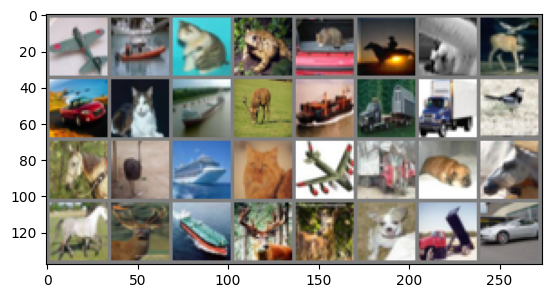

plane  ship   cat  frog   cat horse   cat  deer   car   cat  ship  deer  ship truck truck  bird horse  bird  ship   cat plane truck   dog horse horse  deer  ship  deer  deer   dog truck   car


In [29]:
# define image visualization function
def imshow(img):
    
    # un-normalize image
    img = img / 2 + 0.5  # unnormalize
    
    # transpose and show image
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    
    # plot image
    plt.show()

# retrieve random image batch of first dataloader
images, labels = iter(trainloaders[0]).next()

# create grid plot of image batch 
imshow(torchvision.utils.make_grid(images))

# print labels of image batch
print(' '.join('%5s' % cifar10_classes[labels[j]] for j in range(32)))

The output above shows a random batch of images from the first `trainloader` in our list of ten `trainloaders`. It also prints the labels associated with each image (i.e., one of the ten possible labels we've seen above). If you run the cell again, you should see another batch of images.

### 5.2 Preparing the Model Training and Validation Routines

In a second step, we define the **training routine** that is supposed to be run by each federated client. 

We will use **Adam optimization** and set the **learning-rate to 0.001**. Each mini-batch step the optimizer will update the model parameters $\theta$ values according to the degree of classification error determined by the **Negative Log-Likelihood (NLL)** loss. 

Let's set the training routine hyperparameters accordingly:

In [30]:
# define learning rate and optimization strategy
learning_rate = 0.001

Next, we proceed by implementing a general training routine for each of the federated clients:

In [31]:
# define federated client training routine
def train(model, loader, epochs: int):

    """Train the network on the training set."""

    # init optimization criterion
    criterion = torch.nn.NLLLoss()
    
    # push loss to compute device
    criterion = criterion.to(device)

    # init model optimizer
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

    # set model in train mode
    model.train()

    # iterate over training epochs
    for epoch in range(epochs):

        # init evaluation measures
        correct, total, epoch_loss = 0, 0, 0.0

        # iterate over data loader batches
        for images, labels in loader:

            # push images and labels to compute device
            images, labels = images.to(device), labels.to(device)

            # reset optimizer gradients
            optimizer.zero_grad()

            # run forward pass
            outputs = model(images)

            # compute loss
            loss = criterion(model(images), labels)

            # run backward pass
            loss.backward()

            # update model parameters
            optimizer.step()

            # collect batch loss
            epoch_loss += loss

            # collect batch samples
            total += labels.size(0)

            # collect correctly classified instances
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()

        # compute epoch loss
        epoch_loss /= len(loader.dataset)

        # compute epoch accuracy
        epoch_accuracy = correct / total

        # print training metrics
        now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
        print('[LOG {}] epoch: {} train-loss: {} accuracy: {}'.format(str(now), str(epoch+1), str(round(epoch_loss.item(), 6)), str(round(epoch_accuracy, 4))))

### 5.3 Preparing the Model Validation Routine

In a third step, we define the **validation routine** that is supposed to be run by each federated client. 

We will again use the **Negative Log-Likelihood (NLL)** loss to determine the classification error of a respective client model. In addition, we also compute the **classification accuracy** of the model in terms of the fraction of correctly classified images. 

Next, let's continue and implement the different steps of the validation routine:

In [32]:
# define federated client validation routine
def validate(model, loader):
    
    """Validate the network on the entire test set."""
    
    # define optimization criterion
    criterion = nn.NLLLoss()
    
    # push loss to compute device
    criterion = criterion.to(device)
    
    # init evaluation metrics
    correct, total, loss = 0, 0, 0.0
    
    # set network in eval mode
    model.eval()
    
    # disable gradient computation
    with torch.no_grad():
        
        # iterate over data loader batches
        for images, labels in loader:
            
            # push images and labels to compute device
            images, labels = images.to(device), labels.to(device)
            
            # run model forward pass
            outputs = model(images)
            
            # compute optimization criterion
            loss += criterion(outputs, labels).item()
            
            # determine class predictions
            _, predicted = torch.max(outputs.data, 1)
            
            # determine total number of samples
            total += labels.size(0)
            
            # determine total number of correct classifcations
            correct += (predicted == labels).sum().item()
    
    # compute evaluation loss
    loss /= len(loader.dataset)
    
    # compute evaluation accuracy
    accuracy = correct / total
    
    # return evaluation metrics
    return loss, accuracy

Finally, we have **implemented all the basic building blocks** we required: a dataset, a model, a training function, and a test function. 

Let's put them together to train the model on the dataset of one organization (`trainloaders[0]`). This simulates the reality of most machine learning projects today: each organization has their own data and trains models only on this internal data.

We will run our evaluation for **2 federated rounds** of communication. In each round, the client will train the model for **5 training epochs**. Therefore, we set the following hyperparameters for the evaluation run:

In [33]:
# define number of fl rounds and epochs per round
flrounds = 2
epochs = 5

Let's now proceed and run the simulation for a single organization using the hyperparameter set above:

In [34]:
# get the first train dataloader
trainloader = trainloaders[0]

# get the first validation dataloader
valloader = valloaders[0]

# instantiate model and push compute device
model = CIFAR10Net().to(device)

# iterate over federated rounds
for flround in range(flrounds):

    # train model
    train(model, trainloader, epochs)

    # validate model
    valid_loss, valid_accuracy = validate(model, valloader)

    # print validation metrics
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] valid-loss: {} accuracy: {}'.format(str(now), str(round(valid_loss, 6)), str(round(valid_accuracy, 4))))

# test model
test_loss, test_accuracy = validate(model, testloader)

# print final test metrics
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] final test-loss: {} accuracy: {}'.format(str(now), str(round(test_loss, 6)), str(round(test_accuracy, 4))))

[LOG 20221023-19:32:58] epoch: 1 train-loss: 0.059321 accuracy: 0.2916
[LOG 20221023-19:33:02] epoch: 2 train-loss: 0.049705 accuracy: 0.4087
[LOG 20221023-19:33:07] epoch: 3 train-loss: 0.046587 accuracy: 0.4496
[LOG 20221023-19:33:12] epoch: 4 train-loss: 0.043715 accuracy: 0.4909
[LOG 20221023-19:33:17] epoch: 5 train-loss: 0.041535 accuracy: 0.5213
[LOG 20221023-19:33:18] valid-loss: 0.045176 accuracy: 0.4797
[LOG 20221023-19:33:23] epoch: 1 train-loss: 0.039402 accuracy: 0.5402
[LOG 20221023-19:33:28] epoch: 2 train-loss: 0.037678 accuracy: 0.5662
[LOG 20221023-19:33:33] epoch: 3 train-loss: 0.035993 accuracy: 0.5837
[LOG 20221023-19:33:37] epoch: 4 train-loss: 0.03444 accuracy: 0.5959
[LOG 20221023-19:33:42] epoch: 5 train-loss: 0.033273 accuracy: 0.6156
[LOG 20221023-19:33:43] valid-loss: 0.045391 accuracy: 0.4957
[LOG 20221023-19:33:46] final test-loss: 0.044495 accuracy: 0.5085


Training the simple CNN on our **CIFAR-10 split for 2 rounds and 5 epochs** should result in a test set accuracy of **about 50%**, which is not great, but at the same time, it doesn't really matter for the purposes of this lab. The intent was just to show a simplistic centralized training pipeline that sets the stage **federated learning**.

## 6. Setup Federated Learning Clients

The notebook cells above demonstrated a simple centralized training workflow. Next, we'll prepare a simulation where we have multiple datasets in multiple organizations. Finally, we will train a model over these organizations using federated learning.

### 6.1 Get and Set the Client Model Parameters

In federated learning, the server sends the global model parameters to the client, and the client updates the local model with the parameters received from the server. It then trains the model on the local data (which changes the model parameters locally) and sends the updated/changed model parameters back to the server (or, alternatively, it sends just the gradients back to the server, not the full model parameters).

To establish such a setup in the `Flower` library, we need to implement **two helper functions**. This to **update the local model with parameters received from the server** and to **get the updated model parameters from the local model**. The following two functions do just that for the `PyTorch` model above:

In [35]:
# define the set parameter function -> update local model parameters
def set_parameters(net, parameters: List[np.ndarray]):
    
    # determine parameters dictionary
    params_dict = zip(net.state_dict().keys(), parameters)
    
    # convert to torch tensors to ordered dict
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    
    # load parameters into model
    net.load_state_dict(state_dict, strict=True)

# define the get parameter function -> get local model parameters
def get_parameters(net) -> List[np.ndarray]:
    
    # determine the model parameters as list of numpy arrays
    parameters = [val.cpu().numpy() for _, val in net.state_dict().items()]
    
    # return the model parameters
    return parameters

The details of how both functions work are not really important here (feel free to consult the PyTorch documentation if you want to learn more). In essence, we use `state_dict` to access PyTorch model parameter tensors. The parameter tensors are then converted to/from a list of NumPy ndarray's (which Flower knows how to serialize/deserialize).

### 6.2 Implement Federated Client

With that out of the way, let's move on to the interesting part. Federated learning systems consist of a server and multiple clients. In `Flower`, clients can be created by using the subclass`flwr.client.NumPyClient`. We will use this subclass in this tutorial since it is straightforward to implement. To implement the Flower client, we create a subclass of `flwr.client.NumPyClient` and implement the three methods (i) `get_parameters`, (ii) `fit`, and (iii) `evaluate`. 

> * The `get_parameters` method returns the current local model parameters. 
> * The `fit` method receives model parameters from the server, train the model parameters on the local data, and return the (updated) model parameters to the server. 
> * The `evaluate` method receives model parameters from the server, evaluate the model parameters on the local data, and return the evaluation result to the server.

Next, let's accomplish a simple `Flower` client implementation that brings everything together:

In [36]:
# define federated client
class FederatedClient(fl.client.NumPyClient):

    # init the federated client
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    # define get parameters function
    def get_parameters(self, config):
        return get_parameters(self.net)

    # define model training function
    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=epochs)
        return get_parameters(self.net), len(self.trainloader), {}

    # define model evaluation function
    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = validate(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

The `FlowerClient` client defines how local training/evaluation will be performed and allows `Flowe` to call the local training/evaluation through `fit` and `evaluate`. Each instance of `FlowerClient` represents a *single client* in our federated learning system. 

Federated learning systems have multiple clients (otherwise there's not much to federate), so each client will be represented by its own instance of `FlowerClient`. If we have, for example, three clients in our workload, then we'd have three instances of `FlowerClient`. Flower calls `FlowerClient.fit` on the respective instance when the server selects a particular client for training (and `FlowerClient.evaluate` for evaluation).

### 6.3 Instantiate Federated Client

To enable the `Flower` libray to dynamically create clients when necessary, we need to implement a function called `client_fn` that creates a `FlowerClient` instance on demand. Flower calls `client_fn` whenever it needs an instance of one particular client to call `fit` or `evaluate` (those instances are usually discarded after use, so they should not keep any local state). Clients are identified by a client ID, or short `cid`. The `cid` can be used, for example, to load different local data partitions for different clients, as can be seen below:

In [37]:
def client_fn(cid: str) -> FederatedClient:

    """Create a Flower client representing a single organization."""

    # instantiate client model
    model = CIFAR10Net()

    # push client model to compute device
    model = model.to(device)

    # init the client train dataloader
    trainloader = trainloaders[int(cid)]
    
    # init the client eval dataloader
    valloader = valloaders[int(cid)]
    
    # note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    
    # instantiate a single federated client representing a single organization
    return FederatedClient(model, trainloader, valloader)

We now have the class `FlowerClient` which defines client-side training/evaluation and `client_fn` which allows Flower to create `FlowerClient` instances whenever it needs to call `fit` or `evaluate` on one particular client.

In this lab, we want to simulate a federated learning system with **4 clients on a single machine**. This means that the server and all 4 clients will live on a single machine and share resources such as CPU, GPU, and memory. Having 4 clients would mean having 4 instances of `FlowerClient` in memory. 

Please note, doing such simulations on a single machine can quickly exhaust the available memory resources, even if only a subset of these clients participates in a single round of federated learning.

## 7. Setup and Run Federated Learning Simulation

In the following, we will define a federated evaluation metric and federated learning strategy. Afterwards, we will run our first federated learning simulation using the `Flower`framework. Finally, we will investigate and visualize the obtained results. 

### 7.1 Define Federated Evaluation Metric

In the `Flower` framework we need to define evaluation metrics and how to handle/aggregate these metrics. Let's create a simple weighted averaging function to aggregate the classification `accuracy` metric we return from each federated client via its respective `evaluate` function:

In [38]:
# define weighted average of client's classification accuracy
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    
    """Compute the weighted average accuracy over all federated clients."""

    # determine client accuracies
    accuracies = [m["accuracy"] for _, m in metrics]

    # multiply accuracy of each client by number of examples used
    numerator = [num_examples * m["accuracy"] for num_examples, m in metrics]
    denominator = [num_examples for num_examples, _ in metrics]

    # compute average weighted classification accuracy
    accuracy = round(sum(numerator) / sum(denominator), 4)

    # print validation metrics
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] weighted average accuracy: {}'.format(str(now), str(round(accuracy, 4))))
    
    # aggregate and return custom metric (weighted average)
    return {"accuracy": accuracy, "accuracies": accuracies}

### 7.2 Define Federated Learning Strategy

Flower has a number of built-in strategies, but we can also use our own strategy implementations to customize nearly all aspects of the federated learning approach. For this example, we use the built-in **Federated Averaging (*FedAvg*) strategy** implementation and customize it using a few hyperparameters. 

We set the following hyperparameters of the strategy:

In [39]:
# fraction of clients used during training
fraction_fit=1.0  # Sample 100% of available clients for training

# fraction of clients used during validation 
fraction_evaluate=1.0  # Sample 100% of available clients for evaluation

# minimum number of clients used during training
min_fit_clients=num_clients // 2  # never sample less than 2 clients for training 

# minimum number of clients used during validation
min_evaluate_clients=num_clients // 2  # never sample less than 2 clients for evaluation

# minimum number of total clients in the system
min_available_clients=num_clients  # never run with less than 4 available clientes

Next, we also tell the strategy how to handle/aggregate custom evaluation metrics, and we do so by passing metric aggregation functions to the strategy. The strategy will then call these functions whenever it receives fit or evaluate metrics from clients. To compute the **weighted average classification error** upon each training round we set the `evaluate_metrics_aggregation_fn` parameter accordingly. 

Let's now parametrize and init the *FedAvg* strategy:

In [40]:
# init FedAvg learning strategy
strategy = fl.server.strategy.FedAvg(
        fraction_fit=fraction_fit,
        fraction_evaluate=fraction_evaluate,
        min_fit_clients=min_fit_clients,
        min_evaluate_clients=min_evaluate_clients,
        min_available_clients=num_clients,
        evaluate_metrics_aggregation_fn=weighted_average,  # use predefined metrics aggregation function
)

### 7.3 Run Federated Learning Simulation

Finally, we are able to run an actual federated learning simulation using `flwr.simulation.start_simulation`. To start the simulation we run the `start_simulation` method which - you guessed it - starts the simulation. 

But how will this work? How does the `Flower` library execute this simulation?

When we call `start_simulation`, we tell the `Flower` library that there are 4 clients (`num_clients = 4`). Flower then goes ahead an asks the `FedAvg` strategy to select clients. `FedAvg` knows that it should select 100% of the available clients (`fraction_fit=1.0`), so it goes ahead and selects 4 random clients (i.e., 100% of 4).

Next, the `Flower` libray asks the selected 4 clients to train the model. When the server receives the model parameter updates from the clients, it hands those updates over to the strategy (*FedAvg*) for aggregation. The strategy aggregates those updates and returns the new global model, which then gets used in the next round of federated learning. Let's now start the simulation accordingly:

Before start the simulation we set the number of **federated training rounds** we aim to simulate:

In [41]:
# define number of fl rounds
flrounds = 5

Let's now proceed and start the simulation accordingly:

In [42]:
# start federated learning simulation
simulation_results = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=num_clients,
    config=fl.server.ServerConfig(num_rounds=flrounds),
    strategy=strategy,
)

INFO flower 2022-10-23 15:33:46,076 | app.py:142 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO flower 2022-10-23 15:33:49,267 | app.py:176 | Flower VCE: Ray initialized with resources: {'memory': 14997612544.0, 'CPU': 12.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0}
INFO flower 2022-10-23 15:33:49,270 | server.py:86 | Initializing global parameters
INFO flower 2022-10-23 15:33:49,271 | server.py:270 | Requesting initial parameters from one random client
INFO flower 2022-10-23 15:33:51,817 | server.py:274 | Received initial parameters from one random client
INFO flower 2022-10-23 15:33:51,818 | server.py:88 | Evaluating initial parameters
INFO flower 2022-10-23 15:33:51,819 | server.py:101 | FL starting
DEBUG flower 2022-10-23 15:33:51,820 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=46921) [LOG 20221023-19:34:01] epoch: 1 train-loss: 0.061504 accuracy: 0.2767
(launch_and_fit pid=46917) [LOG 20221023-19:34:03] epoch: 1 train-loss: 0.061126 accuracy: 0.2702
(launch_and_fit pid=46920) [LOG 20221023-19:34:03] epoch: 1 train-loss: 0.05996 accuracy: 0.295
(launch_and_fit pid=46922) [LOG 20221023-19:34:03] epoch: 1 train-loss: 0.061116 accuracy: 0.2745
(launch_and_fit pid=46921) [LOG 20221023-19:34:06] epoch: 2 train-loss: 0.051724 accuracy: 0.3991
(launch_and_fit pid=46920) [LOG 20221023-19:34:08] epoch: 2 train-loss: 0.049888 accuracy: 0.4207
(launch_and_fit pid=46917) [LOG 20221023-19:34:08] epoch: 2 train-loss: 0.051252 accuracy: 0.3929
(launch_and_fit pid=46922) [LOG 20221023-19:34:08] epoch: 2 train-loss: 0.051549 accuracy: 0.4029
(launch_and_fit pid=46921) [LOG 20221023-19:34:11] epoch: 3 train-loss: 0.047633 accuracy: 0.446
(launch_and_fit pid=46917) [LOG 20221023-19:34:13] epoch: 3 train-loss: 0.046698 accuracy: 0.4471
(launch_and_fit pid=469

DEBUG flower 2022-10-23 15:34:23,332 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flower 2022-10-23 15:34:23,343 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flower 2022-10-23 15:34:23,344 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=46920) [LOG 20221023-19:34:23] epoch: 5 train-loss: 0.041121 accuracy: 0.5295
(launch_and_fit pid=46917) [LOG 20221023-19:34:23] epoch: 5 train-loss: 0.040892 accuracy: 0.5236
(launch_and_fit pid=46922) [LOG 20221023-19:34:23] epoch: 5 train-loss: 0.041772 accuracy: 0.5106


DEBUG flower 2022-10-23 15:34:29,239 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
DEBUG flower 2022-10-23 15:34:29,240 | server.py:215 | fit_round 2: strategy sampled 4 clients (out of 4)


[LOG 20221023-19:34:29] weighted average accuracy: 0.3787
(launch_and_fit pid=46921) [LOG 20221023-19:34:38] epoch: 1 train-loss: 0.046174 accuracy: 0.4635
(launch_and_fit pid=46917) [LOG 20221023-19:34:38] epoch: 1 train-loss: 0.045909 accuracy: 0.4732
(launch_and_fit pid=46920) [LOG 20221023-19:34:38] epoch: 1 train-loss: 0.045981 accuracy: 0.4703
(launch_and_fit pid=46922) [LOG 20221023-19:34:38] epoch: 1 train-loss: 0.047098 accuracy: 0.4524
(launch_and_fit pid=46921) [LOG 20221023-19:34:43] epoch: 2 train-loss: 0.04181 accuracy: 0.5157
(launch_and_fit pid=46917) [LOG 20221023-19:34:43] epoch: 2 train-loss: 0.041709 accuracy: 0.5193
(launch_and_fit pid=46920) [LOG 20221023-19:34:43] epoch: 2 train-loss: 0.042725 accuracy: 0.509
(launch_and_fit pid=46922) [LOG 20221023-19:34:44] epoch: 2 train-loss: 0.042269 accuracy: 0.5141
(launch_and_fit pid=46921) [LOG 20221023-19:34:48] epoch: 3 train-loss: 0.038769 accuracy: 0.5518
(launch_and_fit pid=46917) [LOG 20221023-19:34:48] epoch: 3 tr

DEBUG flower 2022-10-23 15:34:58,670 | server.py:229 | fit_round 2 received 4 results and 0 failures
DEBUG flower 2022-10-23 15:34:58,698 | server.py:165 | evaluate_round 2: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=46917) [LOG 20221023-19:34:58] epoch: 5 train-loss: 0.034651 accuracy: 0.6022
(launch_and_fit pid=46922) [LOG 20221023-19:34:58] epoch: 5 train-loss: 0.034906 accuracy: 0.599


DEBUG flower 2022-10-23 15:35:05,286 | server.py:179 | evaluate_round 2 received 4 results and 0 failures
DEBUG flower 2022-10-23 15:35:05,288 | server.py:215 | fit_round 3: strategy sampled 4 clients (out of 4)


[LOG 20221023-19:35:05] weighted average accuracy: 0.5538


(raylet) Spilled 2058 MiB, 22 objects, write throughput 428 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.


(launch_and_fit pid=46921) [LOG 20221023-19:35:16] epoch: 1 train-loss: 0.037625 accuracy: 0.5731
(launch_and_fit pid=46917) [LOG 20221023-19:35:16] epoch: 1 train-loss: 0.038497 accuracy: 0.5649
(launch_and_fit pid=46920) [LOG 20221023-19:35:16] epoch: 1 train-loss: 0.038529 accuracy: 0.5579
(launch_and_fit pid=46922) [LOG 20221023-19:35:16] epoch: 1 train-loss: 0.037458 accuracy: 0.5727
(launch_and_fit pid=46921) [LOG 20221023-19:35:21] epoch: 2 train-loss: 0.03463 accuracy: 0.6032
(launch_and_fit pid=46917) [LOG 20221023-19:35:21] epoch: 2 train-loss: 0.035168 accuracy: 0.5978
(launch_and_fit pid=46920) [LOG 20221023-19:35:21] epoch: 2 train-loss: 0.035502 accuracy: 0.597
(launch_and_fit pid=46922) [LOG 20221023-19:35:21] epoch: 2 train-loss: 0.034409 accuracy: 0.6061
(launch_and_fit pid=46921) [LOG 20221023-19:35:26] epoch: 3 train-loss: 0.032176 accuracy: 0.6378
(launch_and_fit pid=46917) [LOG 20221023-19:35:26] epoch: 3 train-loss: 0.032679 accuracy: 0.6278
(launch_and_fit pid=46

DEBUG flower 2022-10-23 15:35:42,148 | server.py:229 | fit_round 3 received 4 results and 0 failures
DEBUG flower 2022-10-23 15:35:42,161 | server.py:165 | evaluate_round 3: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=46922) [LOG 20221023-19:35:42] epoch: 5 train-loss: 0.027069 accuracy: 0.6882


DEBUG flower 2022-10-23 15:35:49,582 | server.py:179 | evaluate_round 3 received 4 results and 0 failures
DEBUG flower 2022-10-23 15:35:49,583 | server.py:215 | fit_round 4: strategy sampled 4 clients (out of 4)


[LOG 20221023-19:35:49] weighted average accuracy: 0.581
(launch_and_fit pid=46920) [LOG 20221023-19:36:01] epoch: 1 train-loss: 0.033344 accuracy: 0.6231
(launch_and_fit pid=46921) [LOG 20221023-19:36:01] epoch: 1 train-loss: 0.033967 accuracy: 0.6125
(launch_and_fit pid=46917) [LOG 20221023-19:36:01] epoch: 1 train-loss: 0.033539 accuracy: 0.6217
(launch_and_fit pid=46922) [LOG 20221023-19:36:01] epoch: 1 train-loss: 0.034394 accuracy: 0.6131
(launch_and_fit pid=46920) [LOG 20221023-19:36:06] epoch: 2 train-loss: 0.029747 accuracy: 0.661
(launch_and_fit pid=46917) [LOG 20221023-19:36:06] epoch: 2 train-loss: 0.029834 accuracy: 0.6628
(launch_and_fit pid=46921) [LOG 20221023-19:36:06] epoch: 2 train-loss: 0.030139 accuracy: 0.6574
(launch_and_fit pid=46922) [LOG 20221023-19:36:06] epoch: 2 train-loss: 0.030299 accuracy: 0.6551
(launch_and_fit pid=46920) [LOG 20221023-19:36:11] epoch: 3 train-loss: 0.026767 accuracy: 0.6962
(launch_and_fit pid=46921) [LOG 20221023-19:36:11] epoch: 3 tr

DEBUG flower 2022-10-23 15:36:23,503 | server.py:229 | fit_round 4 received 4 results and 0 failures
DEBUG flower 2022-10-23 15:36:23,513 | server.py:165 | evaluate_round 4: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=46917) [LOG 20221023-19:36:23] epoch: 5 train-loss: 0.021917 accuracy: 0.7547
(launch_and_fit pid=46922) [LOG 20221023-19:36:23] epoch: 5 train-loss: 0.022124 accuracy: 0.7478


DEBUG flower 2022-10-23 15:36:30,514 | server.py:179 | evaluate_round 4 received 4 results and 0 failures
DEBUG flower 2022-10-23 15:36:30,514 | server.py:215 | fit_round 5: strategy sampled 4 clients (out of 4)


[LOG 20221023-19:36:30] weighted average accuracy: 0.5866
(launch_and_fit pid=46921) [LOG 20221023-19:36:40] epoch: 1 train-loss: 0.030545 accuracy: 0.6503
(launch_and_fit pid=46920) [LOG 20221023-19:36:40] epoch: 1 train-loss: 0.031048 accuracy: 0.6482
(launch_and_fit pid=46917) [LOG 20221023-19:36:40] epoch: 1 train-loss: 0.030666 accuracy: 0.6523
(launch_and_fit pid=46922) [LOG 20221023-19:36:41] epoch: 1 train-loss: 0.030363 accuracy: 0.6518
(launch_and_fit pid=46921) [LOG 20221023-19:36:45] epoch: 2 train-loss: 0.025821 accuracy: 0.7047
(launch_and_fit pid=46920) [LOG 20221023-19:36:45] epoch: 2 train-loss: 0.026079 accuracy: 0.7044
(launch_and_fit pid=46917) [LOG 20221023-19:36:45] epoch: 2 train-loss: 0.025723 accuracy: 0.7106
(launch_and_fit pid=46922) [LOG 20221023-19:36:46] epoch: 2 train-loss: 0.025374 accuracy: 0.7136
(launch_and_fit pid=46921) [LOG 20221023-19:36:50] epoch: 3 train-loss: 0.022692 accuracy: 0.7414
(launch_and_fit pid=46920) [LOG 20221023-19:36:51] epoch: 3 

(raylet) Spilled 4263 MiB, 46 objects, write throughput 591 MiB/s.


(launch_and_fit pid=46920) [LOG 20221023-19:37:01] epoch: 5 train-loss: 0.017464 accuracy: 0.8012
(launch_and_fit pid=46917) [LOG 20221023-19:37:02] epoch: 5 train-loss: 0.016985 accuracy: 0.8099


DEBUG flower 2022-10-23 15:37:02,627 | server.py:229 | fit_round 5 received 4 results and 0 failures
DEBUG flower 2022-10-23 15:37:02,639 | server.py:165 | evaluate_round 5: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=46922) [LOG 20221023-19:37:02] epoch: 5 train-loss: 0.016426 accuracy: 0.8153


DEBUG flower 2022-10-23 15:37:08,454 | server.py:179 | evaluate_round 5 received 4 results and 0 failures
INFO flower 2022-10-23 15:37:08,454 | server.py:144 | FL finished in 196.6348850170034
INFO flower 2022-10-23 15:37:08,455 | app.py:180 | app_fit: losses_distributed [(1, 0.055986405143737795), (2, 0.03929183926582336), (3, 0.03782120329380035), (4, 0.03919755019664764), (5, 0.04110347250461578)]
INFO flower 2022-10-23 15:37:08,456 | app.py:181 | app_fit: metrics_distributed {'accuracy': [(1, 0.3787), (2, 0.5538), (3, 0.581), (4, 0.5866), (5, 0.5978)], 'accuracies': [(1, [0.36992, 0.38016, 0.38176, 0.38304]), (2, [0.54464, 0.55424, 0.56096, 0.5552]), (3, [0.57984, 0.5808, 0.58752, 0.576]), (4, [0.58144, 0.58336, 0.58496, 0.59648]), (5, [0.59808, 0.59904, 0.58528, 0.60864])]}
INFO flower 2022-10-23 15:37:08,457 | app.py:182 | app_fit: losses_centralized []
INFO flower 2022-10-23 15:37:08,458 | app.py:183 | app_fit: metrics_centralized {}


[LOG 20221023-19:37:08] weighted average accuracy: 0.5978


**Congratulations, you just trained a convolutional neural network, federated over 4 clients!**

Let's, as a final step, also visualize the central weighted averaged learning progress:

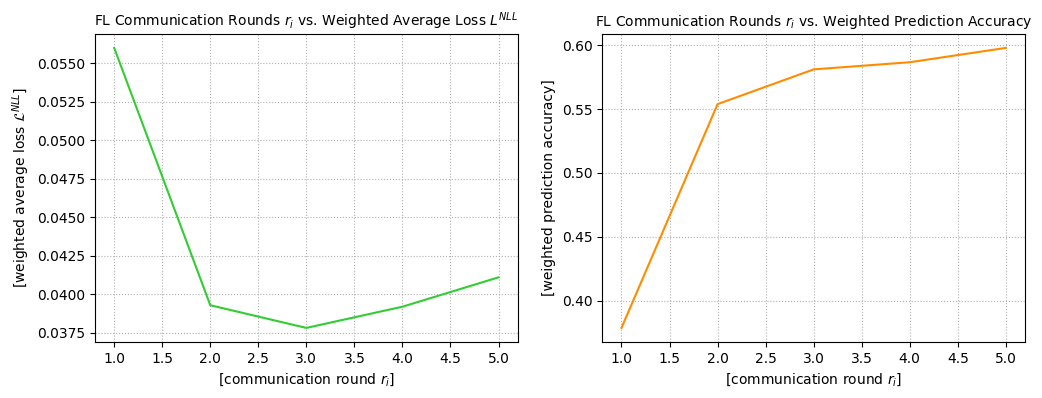

In [43]:
# prepare plot
plt.rcParams['figure.figsize'] = [12, 4]
fig, ax = plt.subplots(ncols=2, nrows=1)

# add grid
ax[0].grid(linestyle='dotted')
ax[1].grid(linestyle='dotted')

# determine train epochs and losses
train_rounds = [ele[0] for ele in simulation_results.losses_distributed]
train_round_losses = [ele[1] for ele in simulation_results.losses_distributed]
train_round_accuracies = [ele[1] for ele in simulation_results.metrics_distributed['accuracy']]

# plot the training epochs vs. the epochs' classification error
ax[0].plot(train_rounds, train_round_losses, color='limegreen')
ax[1].plot(train_rounds, train_round_accuracies, color='darkorange')

# add axis legends
ax[0].set_xlabel('[communication round $r_i$]', fontsize=10)
ax[0].set_ylabel('[weighted average loss $\mathcal{L}^{NLL}$]', fontsize=10)
ax[1].set_xlabel('[communication round $r_i$]', fontsize=10)
ax[1].set_ylabel('[weighted prediction accuracy]', fontsize=10)

# add plot title
ax[0].set_title('FL Communication Rounds $r_i$ vs. Weighted Average Loss $L^{NLL}$', fontsize=10)
ax[1].set_title('FL Communication Rounds $r_i$ vs. Weighted Prediction Accuracy', fontsize=10);

As well as the local individual federated client learning progress:

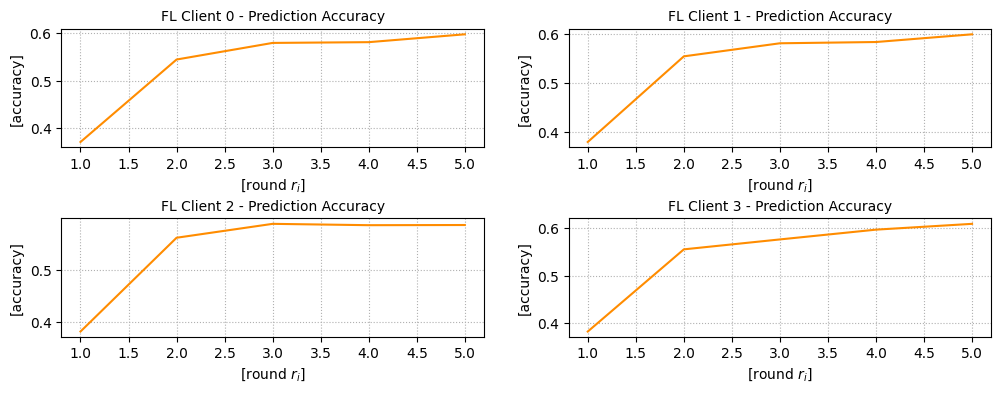

In [44]:
# prepare plot
plt.rcParams['figure.figsize'] = [12, 4]
fig, ax = plt.subplots(ncols=2, nrows=2)

# set subplot spacing
fig.subplots_adjust(hspace=.6)

# client count
client = 0

# iterate over distinct clients
for i in range(0, 2):
    
    # iterate over distinct clients
    for k in range(0, 2):
        
        # add grid
        ax[i, k].grid(linestyle='dotted')

        # determine train epochs and losses
        train_rounds = [ele[0] for ele in simulation_results.losses_distributed]
        train_round_accuracies = [ele[1][client] for ele in simulation_results.metrics_distributed['accuracies']]

        # plot the training epochs vs. the epochs' classification error
        ax[i, k].plot(train_rounds, train_round_accuracies, color='darkorange')

        # add axis legends
        ax[i, k].set_xlabel('[round $r_i$]', fontsize=10)
        ax[i, k].set_ylabel('[accuracy]', fontsize=10)
        
        # add plot title
        ax[i, k].set_title('FL Client {} - Prediction Accuracy'.format(str(client)), fontsize=10)
        
        # increase client count
        client += 1

With that, you understand the basics of federated learning using the `Flower` federated learning framework. The same approach you've seen can be used with other machine learning frameworks (not just PyTorch) and tasks (not just CIFAR-10 images classification), for example NLP with Hugging Face Transformers or speech with SpeechBrain.

## 8. Lab Summary:

In this lab, a step by step introduction into **design, implementation, training and evaluation** of a federated learning workflow is presented. The code presented in this lab may serves as a starting point for developing more complex, more detailed or more tailored federated learning workflows. 